In [1]:
import os
import random
import numpy as np
import pandas as pd

import cv2

from xml.etree import ElementTree as et

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from six import raise_from
from tqdm import tqdm
import csv
import sys 
import io


In [3]:
import collections
import struct

# preprocessing
class UnknownImageFormat(Exception):
    pass

types = collections.OrderedDict()
BMP = types['BMP'] = 'BMP'
GIF = types['GIF'] = 'GIF'
ICO = types['ICO'] = 'ICO'
JPEG = types['JPEG'] = 'JPEG'
PNG = types['PNG'] = 'PNG'
TIFF = types['TIFF'] = 'TIFF'

FILE_UNKNOWN = "Sorry, don't know how to get size for this file."


def get_image_metadata_from_bytesio(input, size, file_path=None):
    height = -1
    width = -1
    data = input.read(26)
    msg = " raised while trying to decode as JPEG."

    if (size >= 10) and data[:6] in (b'GIF87a', b'GIF89a'):
        # GIFs
        imgtype = GIF
        w, h = struct.unpack("<HH", data[6:10])
        width = int(w)
        height = int(h)
    elif ((size >= 24) and data.startswith(b'\211PNG\r\n\032\n')
            and (data[12:16] == b'IHDR')):
        # PNGs
        imgtype = PNG
        w, h = struct.unpack(">LL", data[16:24])
        width = int(w)
        height = int(h)
    elif (size >= 16) and data.startswith(b'\211PNG\r\n\032\n'):
        # older PNGs
        imgtype = PNG
        w, h = struct.unpack(">LL", data[8:16])
        width = int(w)
        height = int(h)
    elif (size >= 2) and data.startswith(b'\377\330'):
        # JPEG
        imgtype = JPEG
        input.seek(0)
        input.read(2)
        b = input.read(1)
        try:
            while (b and ord(b) != 0xDA):
                while (ord(b) != 0xFF):
                    b = input.read(1)
                while (ord(b) == 0xFF):
                    b = input.read(1)
                if (ord(b) >= 0xC0 and ord(b) <= 0xC3):
                    input.read(3)
                    h, w = struct.unpack(">HH", input.read(4))
                    break
                else:
                    input.read(
                        int(struct.unpack(">H", input.read(2))[0]) - 2)
                b = input.read(1)
            width = int(w)
            height = int(h)
        except struct.error:
            raise UnknownImageFormat("StructError" + msg)
        except ValueError:
            raise UnknownImageFormat("ValueError" + msg)
        except Exception as e:
            raise UnknownImageFormat(e.__class__.__name__ + msg)
    elif (size >= 26) and data.startswith(b'BM'):
        # BMP
        imgtype = 'BMP'
        headersize = struct.unpack("<I", data[14:18])[0]
        if headersize == 12:
            w, h = struct.unpack("<HH", data[18:22])
            width = int(w)
            height = int(h)
        elif headersize >= 40:
            w, h = struct.unpack("<ii", data[18:26])
            width = int(w)
            # as h is negative when stored upside down
            height = abs(int(h))
        else:
            raise UnknownImageFormat(
                "Unkown DIB header size:" +
                str(headersize))
    elif (size >= 8) and data[:4] in (b"II\052\000", b"MM\000\052"):
        # Standard TIFF, big- or little-endian
        # BigTIFF and other different but TIFF-like formats are not
        # supported currently
        imgtype = TIFF
        byteOrder = data[:2]
        boChar = ">" if byteOrder == "MM" else "<"
        # maps TIFF type id to size (in bytes)
        # and python format char for struct
        tiffTypes = {
            1: (1, boChar + "B"),  # BYTE
            2: (1, boChar + "c"),  # ASCII
            3: (2, boChar + "H"),  # SHORT
            4: (4, boChar + "L"),  # LONG
            5: (8, boChar + "LL"),  # RATIONAL
            6: (1, boChar + "b"),  # SBYTE
            7: (1, boChar + "c"),  # UNDEFINED
            8: (2, boChar + "h"),  # SSHORT
            9: (4, boChar + "l"),  # SLONG
            10: (8, boChar + "ll"),  # SRATIONAL
            11: (4, boChar + "f"),  # FLOAT
            12: (8, boChar + "d")   # DOUBLE
        }
        ifdOffset = struct.unpack(boChar + "L", data[4:8])[0]
        try:
            countSize = 2
            input.seek(ifdOffset)
            ec = input.read(countSize)
            ifdEntryCount = struct.unpack(boChar + "H", ec)[0]
            # 2 bytes: TagId + 2 bytes: type + 4 bytes: count of values + 4
            # bytes: value offset
            ifdEntrySize = 12
            for i in range(ifdEntryCount):
                entryOffset = ifdOffset + countSize + i * ifdEntrySize
                input.seek(entryOffset)
                tag = input.read(2)
                tag = struct.unpack(boChar + "H", tag)[0]
                if (tag == 256 or tag == 257):
                    # if type indicates that value fits into 4 bytes, value
                    # offset is not an offset but value itself
                    type = input.read(2)
                    type = struct.unpack(boChar + "H", type)[0]
                    if type not in tiffTypes:
                        raise UnknownImageFormat(
                            "Unkown TIFF field type:" +
                            str(type))
                    typeSize = tiffTypes[type][0]
                    typeChar = tiffTypes[type][1]
                    input.seek(entryOffset + 8)
                    value = input.read(typeSize)
                    value = int(struct.unpack(typeChar, value)[0])
                    if tag == 256:
                        width = value
                    else:
                        height = value
                if width > -1 and height > -1:
                    break
        except Exception as e:
            raise UnknownImageFormat(str(e))
    elif size >= 2:
        # see http://en.wikipedia.org/wiki/ICO_(file_format)
        imgtype = 'ICO'
        input.seek(0)
        reserved = input.read(2)
        if 0 != struct.unpack("<H", reserved)[0]:
            raise UnknownImageFormat(FILE_UNKNOWN)
        format = input.read(2)
        assert 1 == struct.unpack("<H", format)[0]
        num = input.read(2)
        num = struct.unpack("<H", num)[0]
        if num > 1:
            import warnings
            warnings.warn("ICO File contains more than one image")
        # http://msdn.microsoft.com/en-us/library/ms997538.aspx
        w = input.read(1)
        h = input.read(1)
        width = ord(w)
        height = ord(h)
    else:
        raise UnknownImageFormat(FILE_UNKNOWN)

    return Image(path=file_path,
                 type=imgtype,
                 file_size=size,
                 width=width,
                 height=height)


def get_image_metadata(file_path):
    size = os.path.getsize(file_path)
    with io.open(file_path, "rb") as input:
        return get_image_metadata_from_bytesio(input, size, file_path)


def get_image_size(file_path):
    img = get_image_metadata(file_path)
    return (img.width, img.height)


In [4]:
def _parse(value, function, fmt):
    try:
        return function(value)
    except ValueError as e:
        raise_from(ValueError(fmt.format(e)), None)


def _open_for_csv(path):
    return open(path, 'r', newline='')


def _read_classes(csv_reader):
    result = {}
    for line, row in enumerate(csv_reader):
        line += 1
        try:
            class_name, class_id = row
        except ValueError as e:
            raise_from(
                e('line {}: format should be \'class_name,class_id\''.format(line)), None)
        class_id = _parse(
            class_id, int, 'line {}: malformed class ID: {{}}'.format(line))
        if class_name in result:
            raise ValueError(
                'line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
    return result


def _read_images(base_dir):

    result = {}
    dirs = [os.path.join(base_dir, o) for o in os.listdir(
        base_dir) if os.path.isdir(os.path.join(base_dir, o))]
    if len(dirs) == 0:
        dirs = ['']
    for project in dirs:
        project_imgs = os.listdir(os.path.join(base_dir, project))
        i = 0
        print("Loading images...")
        for image in tqdm(project_imgs):
            try:
                img_file = os.path.join(base_dir, project, image)
                # Check images exists
                exists = os.path.isfile(img_file)

                if not exists:
                    print("Warning: Image file {} is not existing".format(img_file))
                    continue

                # Image shape
                height, width = get_image_size(img_file)
                result[img_file] = {"width": width, "height": height}
                i += 1
                # if i == 10:
                #     break
            except Exception as e:
                print("Error: {} in image: {}".format(str(e), img_file))
                continue
            exit()

    return result


def _read_annotations(csv_reader, classes, base_dir, image_existence):
    """ Read annotations from the csv_reader.
    """
    result = {}
    for line, row in enumerate(csv_reader):
        line += 1

        try:
            img_file, x1, y1, x2, y2, class_name, width, height = row[:]
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            width = int(width)
            height = int(height)

            if x1 >= width:
                x1 = width - 1
            if x2 >= width:
                x2 = width - 1

            if y1 > height:
                y1 = height - 1
            if y2 >= height:
                y2 = height - 1
            # x1 < 0 | y1 < 0 | x2 <= 0 | y2 <= 0
            if x1 < 0 or y1 < 0 or x2 <= 0 or y2 <= 0:
                print(
                    "Warning: Image file {} has some bad boxes annotations".format(img_file))
                continue

            # Append root path
            img_file = os.path.join(base_dir, img_file)
            # Check images exists
            if img_file not in image_existence:
                print("Warning: Image file {} is not existing".format(img_file))
                continue

        except ValueError:
            raise_from(ValueError(
                'line {}: format should be \'img_file,x1,y1,x2,y2,class_name\' or \'img_file,,,,,\''.format(line)),
                None)

        if img_file not in result:
            result[img_file] = []

        # If a row contains only an image path, it's an image without annotations.
        if (x1, y1, x2, y2, class_name) == ('', '', '', '', ''):
            continue

        x1 = _parse(x1, int, 'line {}: malformed x1: {{}}'.format(line))
        y1 = _parse(y1, int, 'line {}: malformed y1: {{}}'.format(line))
        x2 = _parse(x2, int, 'line {}: malformed x2: {{}}'.format(line))
        y2 = _parse(y2, int, 'line {}: malformed y2: {{}}'.format(line))

        # Check that the bounding box is valid.
        if x2 <= x1:
            raise ValueError(
                'line {}: x2 ({}) must be higher than x1 ({})'.format(line, x2, x1))
        if y2 <= y1:
            raise ValueError(
                'line {}: y2 ({}) must be higher than y1 ({})'.format(line, y2, y1))

        # check if the current class name is correctly present
        if class_name not in classes:
            raise ValueError('line {}: unknown class name: \'{}\' (classes: {})'.format(
                line, class_name, classes))

        result[img_file].append(
            {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': class_name})
    return result


In [5]:
class GroceryImagesDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, csv_data_file, csv_class_file, transforms=None):
        #D:\CAPSTONE\SKU110K_fixed\images
        self.base_dir = base_dir
        self.transforms = transforms

        self.image_names = []
        self.image_data = []
        self.classes = []
        self.labels = []
        self.image_existence = _read_images(self.base_dir)
        
        exit()

        #classes
        try:
            with _open_for_csv(csv_class_file) as file:
                self.classes = _read_classes(csv.reader(file, delimiter=","))
        except ValueError as e:
            raise_from(ValueError(
                'invalid CSV class file: {}: {}'.format(csv_class_file, e)), None)
        #labels
        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key
        #read annotation
        try:
            with _open_for_csv(csv_data_file) as file:
                self.image_data = _read_annotations(csv.reader(file, delimiter=','), self.classes, self.base_dir, self.image_existence)
        except ValueError as e:
            raise_from(ValueError('invalid CSV annotations file: {}: {}'.format(csv_data_file, e)), None)
        self.image_names = list(self.image_data.keys())
    


In [6]:
base_dir = "../SKU110K_fixed/images/"
csv_data_file = "../SKU110K_fixed/annotations/annotations_train.csv"
csv_class_file = "../SKU110K_fixed/classes/class_mappings.csv"

test_dataset = GroceryImagesDataset(base_dir=base_dir, csv_data_file=csv_data_file, csv_class_file=csv_class_file)


In [2]:
files_dir = '../QuickStart/data/fruit-images-for-object-detection/train_zip/train'
test_dir = '../QuickStart/data/fruit-images-for-object-detection/test_zip/test'

class FruitImagesDataset(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        self.imgs = [img for img in sorted(os.listdir(files_dir)) if img[-4:]=='.jpg']
        self.classes = [_, 'apple', 'banana', 'orange']
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res = img_res/255.0

        annot_filename = img_name[:-4]+'.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        wt = img.shape[1]
        ht = img.shape[0]

        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd

        image_id = torch.tensor([idx])
        target['image_id'] = image_id

        if self.transforms:
            sample = self.transforms(image = img_res, bboxes = target['boxes'], labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)



dataset = FruitImagesDataset(files_dir, 224, 224)
print('length of dataset = {}'.format(len(dataset)))

img, target = dataset[78]
print(img.shape, '\n', target)

length of dataset = 240
(224, 224, 3) 
 {'boxes': tensor([[ 22.4000,  36.4903, 163.1000,  68.6452],
        [ 24.8500,  39.3806, 163.4500,  94.2968],
        [ 28.0000,  52.3871, 166.9500, 127.8968],
        [ 71.0500,  59.6129, 193.9000, 157.5226]]), 'labels': tensor([2, 2, 2, 2]), 'area': tensor([ 4524.1865,  7611.3750, 10492.0693, 12028.2041]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([78])}


In [3]:
dataset = FruitImagesDataset(files_dir, 224, 224)
for img, target in iter(dataset):
    print(target['labels'])

tensor([1])
tensor([1])
tensor([1, 1, 1])
tensor([1])
tensor([1, 1, 1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1, 1])
tensor([1])
tensor([1, 1, 1])
tensor([1, 1, 1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1])
tensor([1, 1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1, 1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1, 1])
tensor([1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1])
tensor([1, 1])
tensor([1])
tensor([1, 1, 1, 1, 1, 1])
tensor([1, 1, 1])
tensor([1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1])
tensor([1])
tensor([1, 1, 1])
tensor([1])
tensor([1])
tensor([1, 1])
tensor([1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1])
tensor([1])
tensor([1])
tensor([1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1])
tensor([1])
tensor([1, 1])
tensor([1, 1, 1])
tensor([1])
tensor([1])
tensor(

In [4]:
img, target = dataset[50]
print(img.shape, '\n', target)

(224, 224, 3) 
 {'boxes': tensor([[ 65.1467,  56.4978, 160.7200, 195.1289]]), 'labels': tensor([1]), 'area': tensor([13249.4385]), 'iscrowd': tensor([0]), 'image_id': tensor([50])}


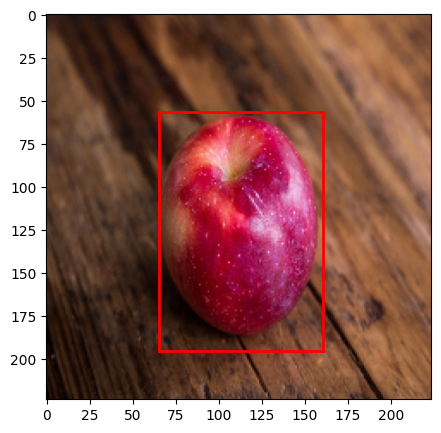

In [5]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], abs(box[2]-box[0]), abs(box[3]-box[1])
        rect = patches.Rectangle((x,y), width, height,
                                 linewidth=2, edgecolor = 'r', facecolor='none')
        a.add_patch(rect)
    plt.show()

img, target = dataset[50]
plot_img_bbox(img, target)


In [6]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [7]:
dataset = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [29]:
import torch.nn 
import torchvision
from torchvision.models.detection import RetinaNet 
from torchvision.models.resnet import resnet50
from torchvision.models.detection import backbone_utils
from torchvision.ops.misc import FrozenBatchNorm2d
from torchvision.ops.feature_pyramid_network import LastLevelP6P7

trainable_backbone_layers = backbone_utils._validate_trainable_layers(
    is_trained=True, trainable_backbone_layers=None, max_value=5, default_value=3
)
norm_layer = FrozenBatchNorm2d
backbone = resnet50(weights="IMAGENET1K_V1", progress=True, norm_layer=norm_layer)
backbone = backbone_utils._resnet_fpn_extractor(
    backbone, trainable_backbone_layers, returned_layers=[2, 3, 4],
    extra_blocks=LastLevelP6P7(256,256)
)
model = RetinaNet(backbone, num_classes=2)


In [13]:
from torchvision.models.detection import retinanet_resnet50_fpn, RetinaNet
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision import ops
from torch import nn
import torchvision

def build_model(num_classes: int):
    model = retinanet_resnet50_fpn(weights="DEFAULT")
    in_channels = model.head.classification_head.cls_logits.in_channels
    num_anchor = model.head.classification_head.num_anchors
    norm_layer = nn.BatchNorm2d #misc_nn_ops.FrozenBatchNorm2d if is trained
    model.head.classification_head = RetinaNetClassificationHead(
        in_channels=in_channels, num_anchors=num_anchor, num_classes=num_classes, norm_layer=norm_layer)
    return model


In [18]:
def build_model2(num_classes: int):
    model = retinanet_resnet50_fpn(weights="DEFAULT")
    out_channels = model.backbone.out_channels
    anchor_generator =torchvision.models.detection.retinanet._default_anchorgen()    
    head = torchvision.models.detection.retinanet.RetinaNetHead(out_channels, anchor_generator.num_anchors_per_location()[0], num_classes)
    return model


In [19]:
model = build_model2(num_classes=4)


In [69]:
dataset = FruitImagesDataset(files_dir, 480, 480, transforms= get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True,
    collate_fn=utils.collate_fn)
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k:v for k,v in t.items()} for t in targets]
output = model(images, targets)

In [70]:
#model = retinanet_resnet50_fpn(weights="DEFAULT")
model.eval()
predictions = model(images)

In [71]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': tensor([], dtype=torch.int64)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'scores': tensor([], grad_fn=<IndexBackward0>),
  'labels': tensor([], dtype=torch.int64)}]

In [54]:
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 4

model = build_model(num_classes=4)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [9]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

KeyboardInterrupt: 